In [1]:
import pyspark.sql as pyspark_sql
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [3]:
# SparkSession creation
spark = pyspark_sql.SparkSession.builder.appName("Statistics").getOrCreate()

In [4]:
all_data = spark.read.csv(r"../data/processed/all_data.csv", header=True, inferSchema=True)

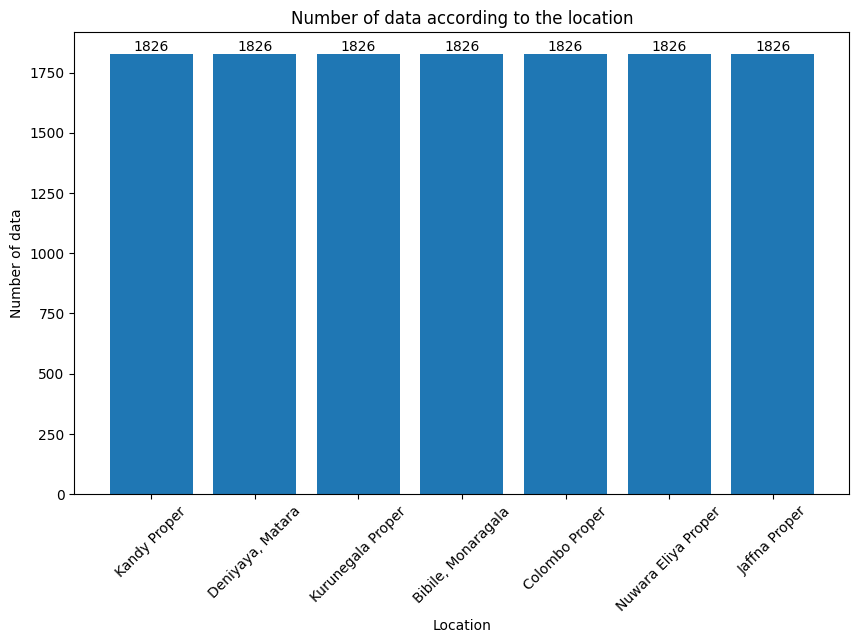

In [5]:
# Visualize a histogram of the number of data points according to location
location_count = all_data.groupBy("location").count().toPandas()

plt.figure(figsize=(10, 6))
plt.bar(location_count["location"], location_count["count"])
plt.xlabel("Location")
plt.ylabel("Number of data")
plt.title("Number of data according to the location")
plt.xticks(rotation=45)

# Add counts to each bar
for i, count in enumerate(location_count["count"]):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

## Checking Null Values

In [6]:
# Number of null values in each column for entire dataset
all_data.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in all_data.columns]).show()

+------------+------------+--------+
|current_date|hcho_reading|location|
+------------+------------+--------+
|           0|           0|       0|
+------------+------------+--------+



No null values

## Calculate Statistics

#### For entire dataset

In [7]:
all_data.select("hcho_reading").summary().show(truncate=False)

+-------+---------------------+
|summary|hcho_reading         |
+-------+---------------------+
|count  |12782                |
|mean   |1.2336539018487143E-4|
|stddev |7.62527471623086E-5  |
|min    |8.48560045610269E-8  |
|25%    |6.46201021380951E-5  |
|50%    |1.119915697798E-4    |
|75%    |1.704588214359E-4    |
|max    |3.680863948475E-4    |
+-------+---------------------+



In [8]:
# Variance and IQR for "hcho_reading" column for entire dataset
variance = all_data.select(F.variance("hcho_reading")).collect()[0][0]
iqr = all_data.approxQuantile("hcho_reading", [0.75, 0.25], 0)
iqr = iqr[0] - iqr[1]
print(f"Variance: {variance}")
print(f"IQR: {iqr}")

Variance: 5.814481449798962e-09
IQR: 0.0001058387192978049


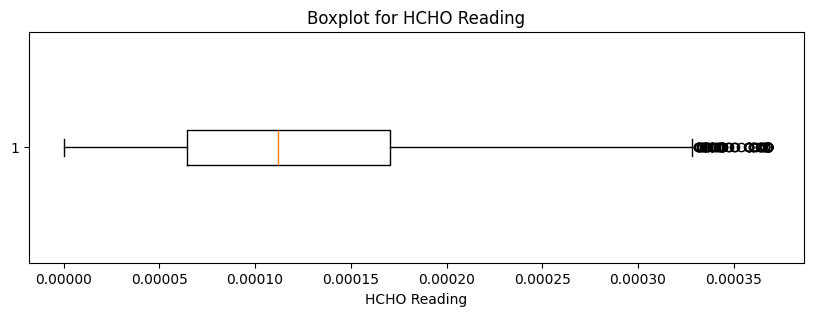

In [9]:
# Boxplot for hcho_reading column for entire dataset
hcho_reading = all_data.select("hcho_reading").toPandas()

plt.figure(figsize=(10, 3))
plt.boxplot(hcho_reading["hcho_reading"].dropna(), vert=False)
plt.xlabel("HCHO Reading")
plt.title("Boxplot for HCHO Reading")
plt.show()

#### For Each Location

In [10]:
# Describe the data for each city only for "hcho_reading" column
all_data.groupBy("location").agg(F.count("hcho_reading").alias("Count"),
                                 F.percentile("hcho_reading", 0.25).alias("Q1"),
                                 F.median("hcho_reading").alias("median"),
                                 F.percentile("hcho_reading", 0.75).alias("Q3"),
                                 F.min("hcho_reading").alias("minimum value"),
                                 F.max("hcho_reading").alias("maximum value")).show(truncate=False)

+-------------------+-----+---------------------+--------------------+---------------------+---------------------+-----------------+
|location           |Count|Q1                   |median              |Q3                   |minimum value        |maximum value    |
+-------------------+-----+---------------------+--------------------+---------------------+---------------------+-----------------+
|Kandy Proper       |1826 |5.949028317054378E-5 |1.121188925967E-4   |1.605259690598E-4    |1.569671117488859E-7 |2.99499479458E-4 |
|Deniyaya, Matara   |1826 |4.995612057224007E-5 |9.172827110939618E-5|1.52568933303325E-4  |8.48560045610269E-8  |3.06189795462E-4 |
|Kurunegala Proper  |1826 |7.943533561838486E-5 |1.223631523382E-4   |1.839836498268E-4    |1.4333763162876774E-7|3.089663063998E-4|
|Bibile, Monaragala |1826 |7.107366049214687E-5 |1.232948475055E-4   |1.8278758131905004E-4|1.4612316831653266E-7|3.168229543187E-4|
|Colombo Proper     |1826 |9.747576626042276E-5 |1.4856869650665E-4  

In [11]:
# Describe the data for each city only for "hcho_reading" column
all_data.groupBy("location").agg(F.mean("hcho_reading").alias("mean"),
                                 F.stddev("hcho_reading").alias("standard deviation"),
                                 F.variance("hcho_reading").alias("variance")).show(truncate=False)

+-------------------+---------------------+--------------------+--------------------+
|location           |mean                 |standard deviation  |variance            |
+-------------------+---------------------+--------------------+--------------------+
|Kandy Proper       |1.1656192852661496E-4|7.259704683921048E-5|5.270331209774521E-9|
|Deniyaya, Matara   |1.0612886363677951E-4|7.207677821641975E-5|5.195061958058961E-9|
|Kurunegala Proper  |1.346130448795259E-4 |7.240686055856123E-5|5.24275345594693E-9 |
|Bibile, Monaragala |1.3043293986907852E-4|7.678208092393502E-5|5.895487951009706E-9|
|Colombo Proper     |1.613177966224625E-4 |8.711143213733023E-5|7.588401609016691E-9|
|Nuwara Eliya Proper|1.0237668184506603E-4|6.906368280236762E-5|4.769792282226049E-9|
|Jaffna Proper      |1.1212647591457743E-4|6.504001792532868E-5|4.230203931727075E-9|
+-------------------+---------------------+--------------------+--------------------+



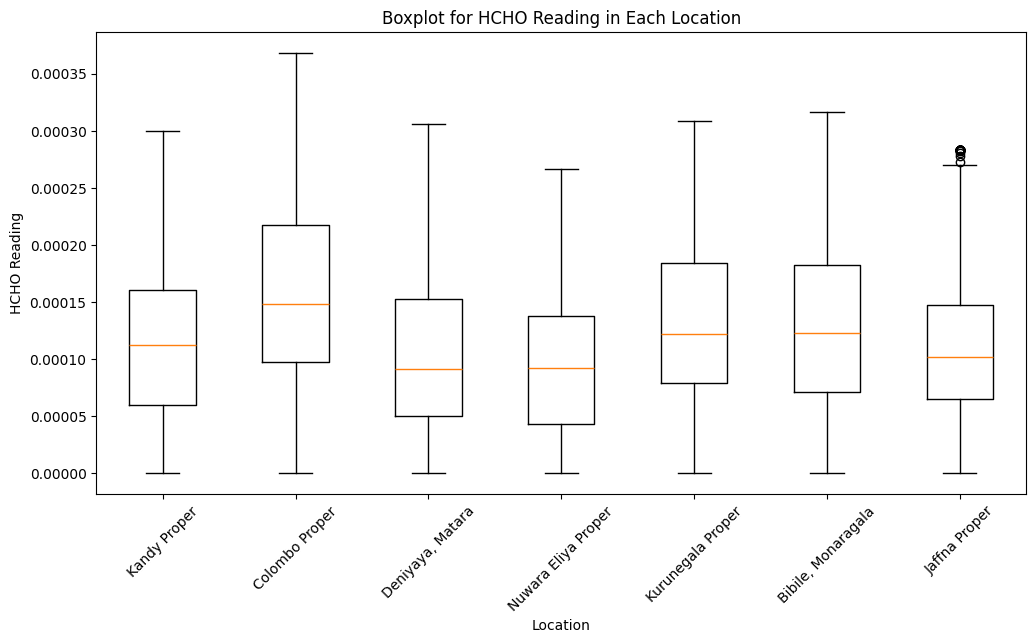

In [12]:
# Plot the boxplot for each city
location_hcho_reading = all_data.select("location", "hcho_reading").toPandas()
locations = location_hcho_reading['location'].unique()

plt.figure(figsize=(12, 6))
plt.boxplot([location_hcho_reading[location_hcho_reading["location"] == location]["hcho_reading"] for location in locations])
plt.xlabel("Location")
plt.ylabel("HCHO Reading")
plt.title("Boxplot for HCHO Reading in Each Location")
plt.xticks(range(1, len(locations)+1), locations, rotation=45)

plt.show()

## Data Distribution

#### For Entire Dataset

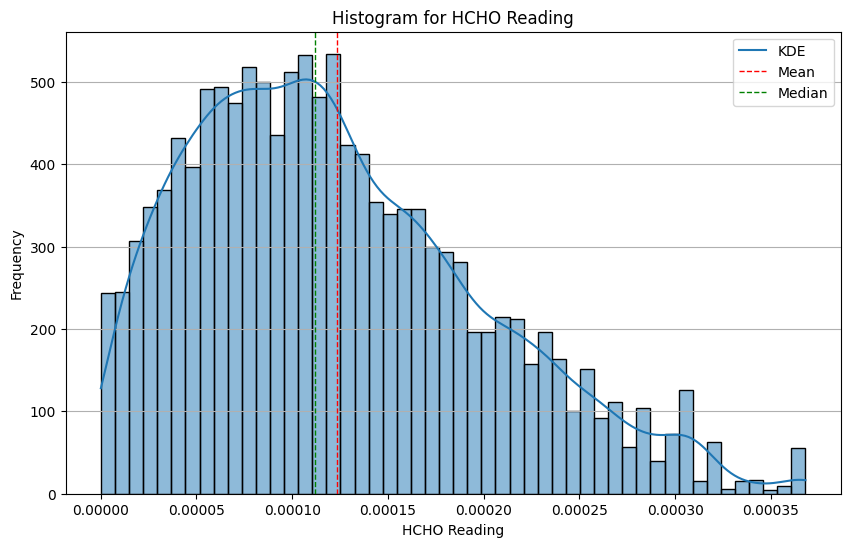

In [13]:
# Plot histogram for entire dataset for "hcho_reading"

hcho_reading = all_data.select("hcho_reading").toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(hcho_reading["hcho_reading"], bins=50, kde=True)
plt.xlabel("HCHO Reading")
plt.ylabel("Frequency")
plt.title("Histogram for HCHO Reading")

# draw mean and median lines
mean = hcho_reading["hcho_reading"].mean()
median = hcho_reading["hcho_reading"].median()
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
plt.axvline(median, color='g', linestyle='dashed', linewidth=1)
plt.grid(axis='y')

plt.legend({"KDE": "KDE","Mean": mean, "Median": median})

plt.show()

#### For each location

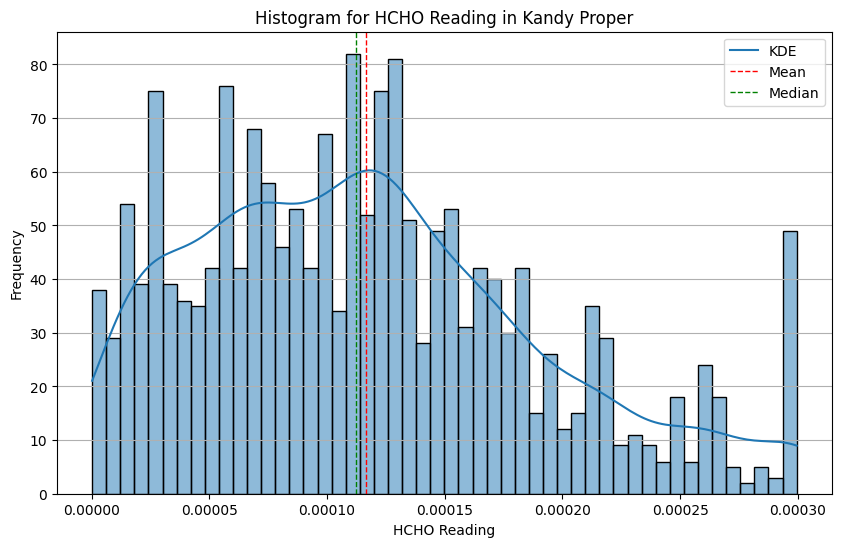

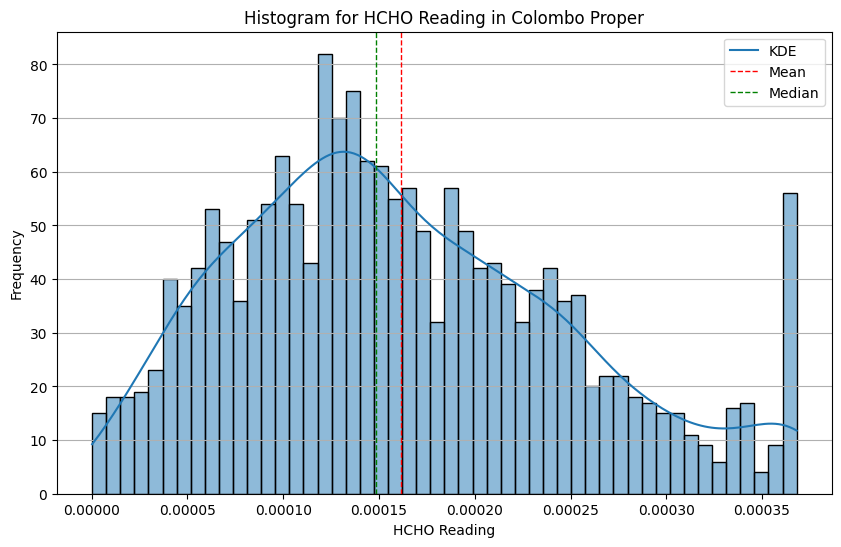

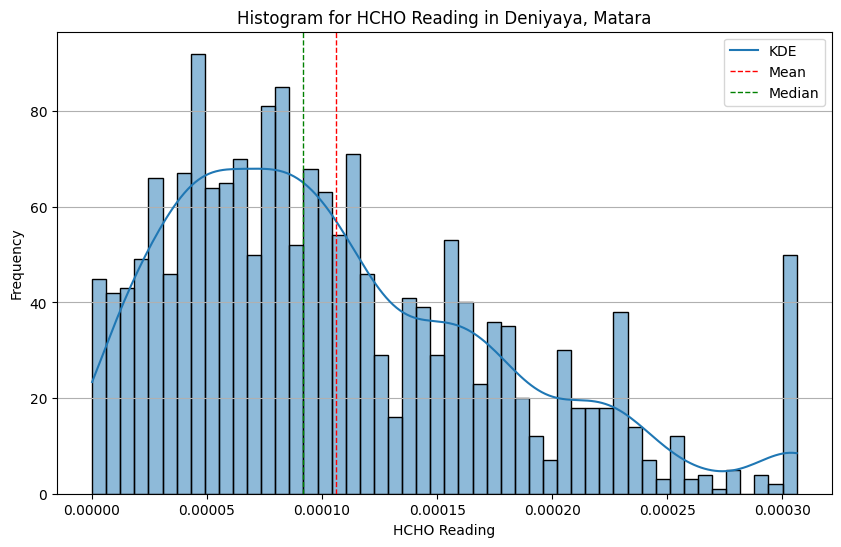

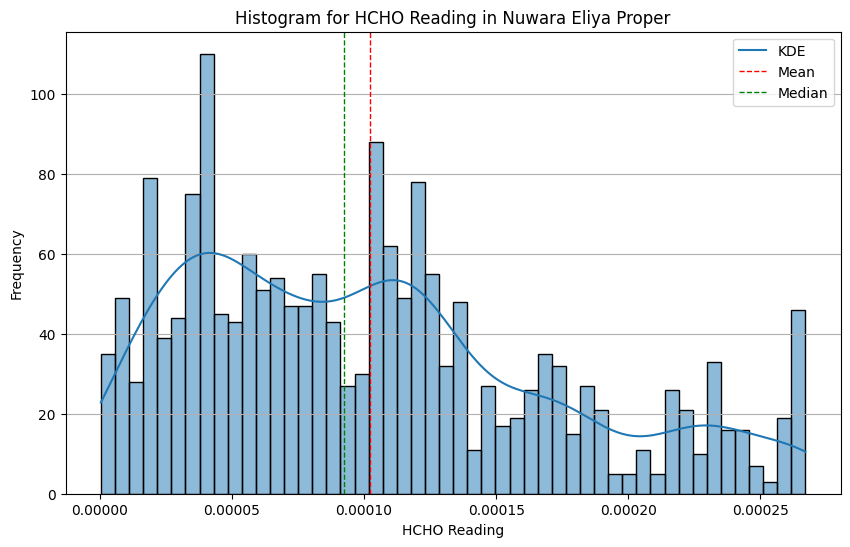

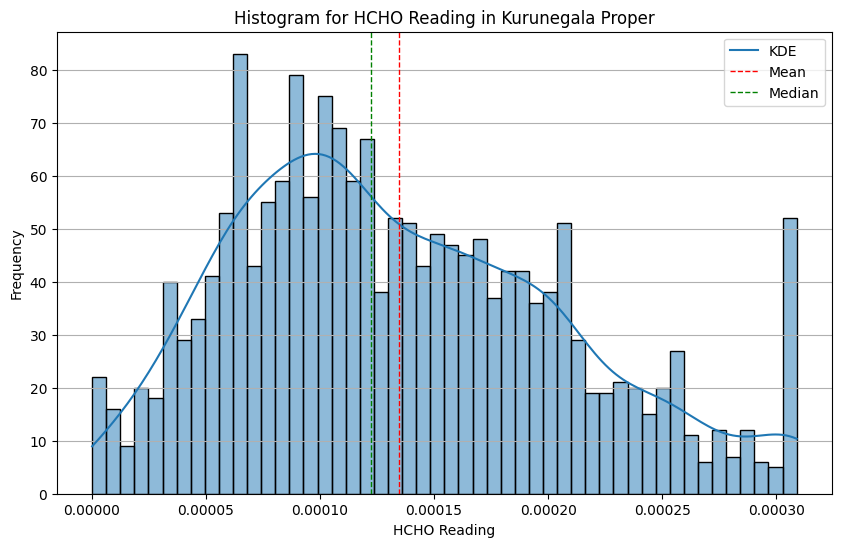

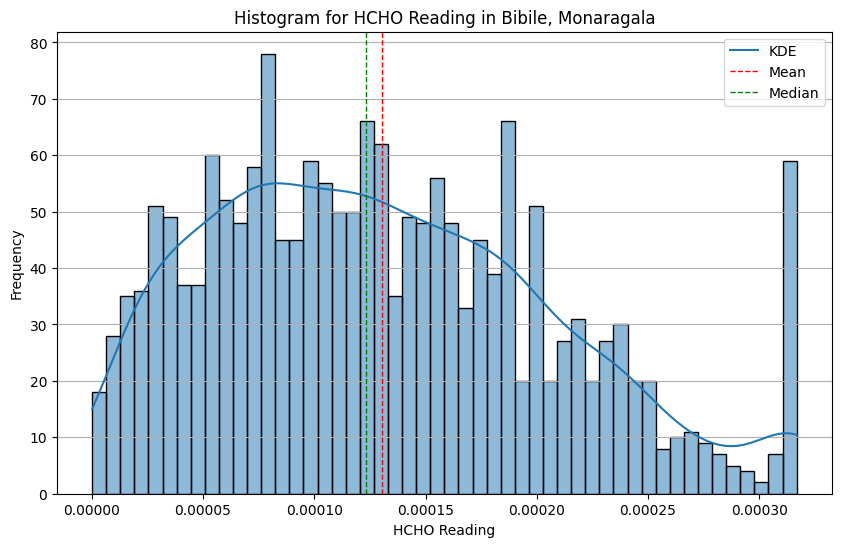

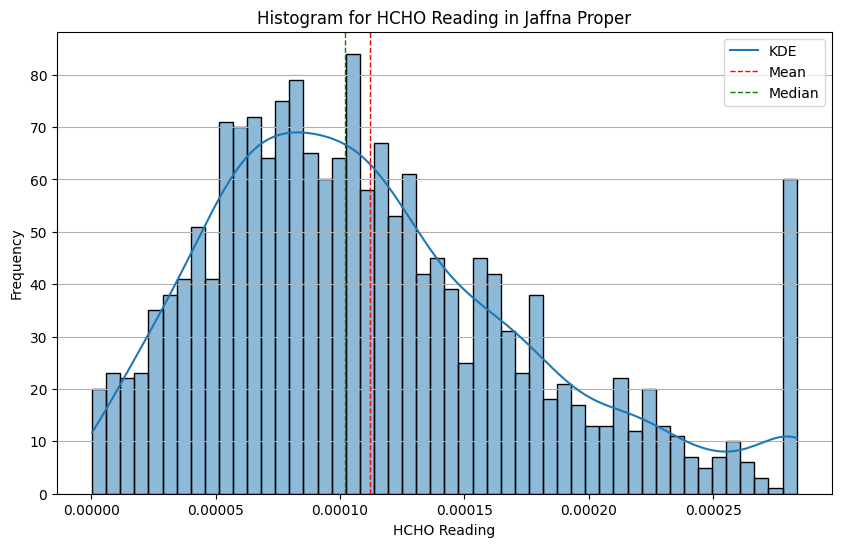

In [14]:
# Plot histogram for each city for "hcho_reading"
location_hcho_reading = all_data.select("location", "hcho_reading").toPandas()
locations = location_hcho_reading['location'].unique()

for location in locations:
    plt.figure(figsize=(10, 6))
    sns.histplot(location_hcho_reading[location_hcho_reading["location"] == location]["hcho_reading"], bins=50, kde=True)
    plt.xlabel("HCHO Reading")
    plt.ylabel("Frequency")
    plt.title("Histogram for HCHO Reading in " + location)

    # draw mean and median lines
    mean = location_hcho_reading[location_hcho_reading["location"] == location]["hcho_reading"].mean()
    median = location_hcho_reading[location_hcho_reading["location"] == location]["hcho_reading"].median()
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
    plt.axvline(median, color='g', linestyle='dashed', linewidth=1)
    plt.grid(axis='y')

    plt.legend({"KDE": "KDE", "Mean": mean, "Median": median})

    plt.show()

## Average HCHO Reading by Year

#### For Entire Dataset

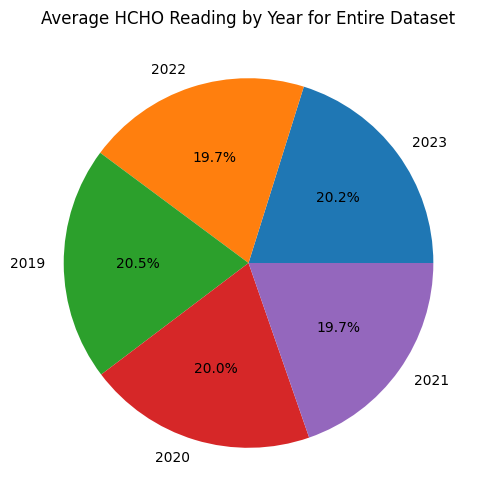

In [15]:
# Draw pie chart for average hcho_reading by year for entire dataset
all_data = all_data.withColumn("year", F.year("current_date"))

year_hcho_reading = all_data.groupBy("year").agg(F.mean("hcho_reading").alias("average_hcho_reading")).toPandas()

plt.figure(figsize=(10, 6))
plt.pie(year_hcho_reading["average_hcho_reading"], labels=year_hcho_reading["year"], autopct='%1.1f%%')
plt.title("Average HCHO Reading by Year for Entire Dataset")
plt.show()

#### For Each Location

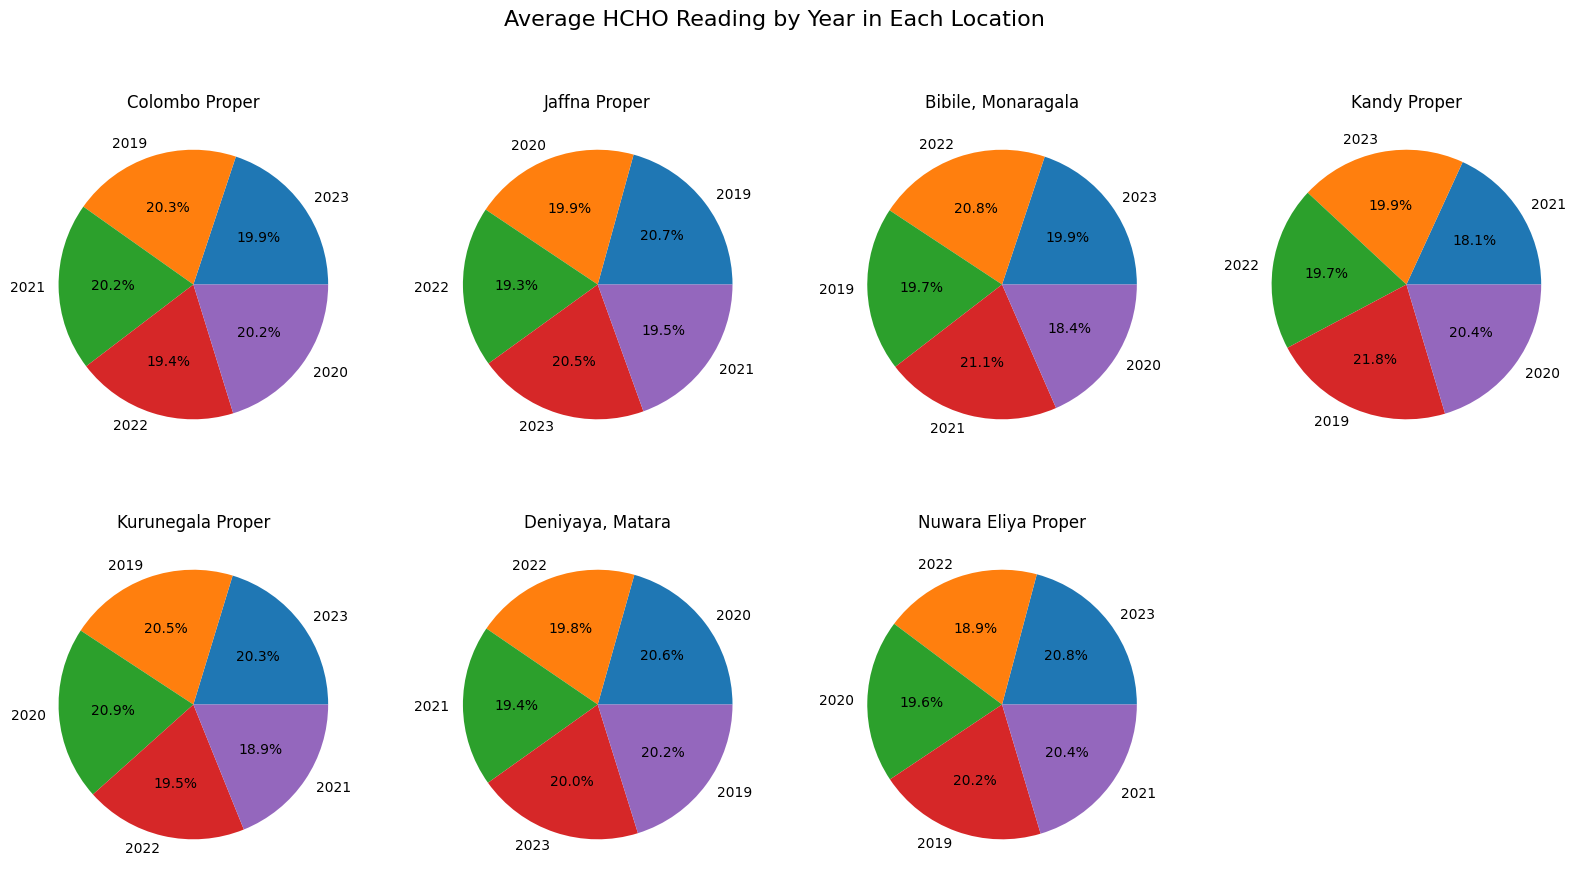

In [16]:
# Draw pie chart for average hcho_reading by year for each city
location_year_hcho_reading = all_data.groupBy("location", "year").agg(F.mean("hcho_reading").alias("average_hcho_reading")).toPandas()

locations = location_year_hcho_reading['location'].unique()

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Average HCHO Reading by Year in Each Location", fontsize=16)

axs = axs.flatten()

for i, location in enumerate(locations):
    location_data = location_year_hcho_reading[location_year_hcho_reading["location"] == location]
    axs[i].pie(location_data["average_hcho_reading"], labels=location_data["year"], autopct='%1.1f%%')
    axs[i].set_title(location)

# Hide remaining subplots if not used
for j in range(len(locations), 2*4):
    fig.delaxes(axs[j])

plt.show()

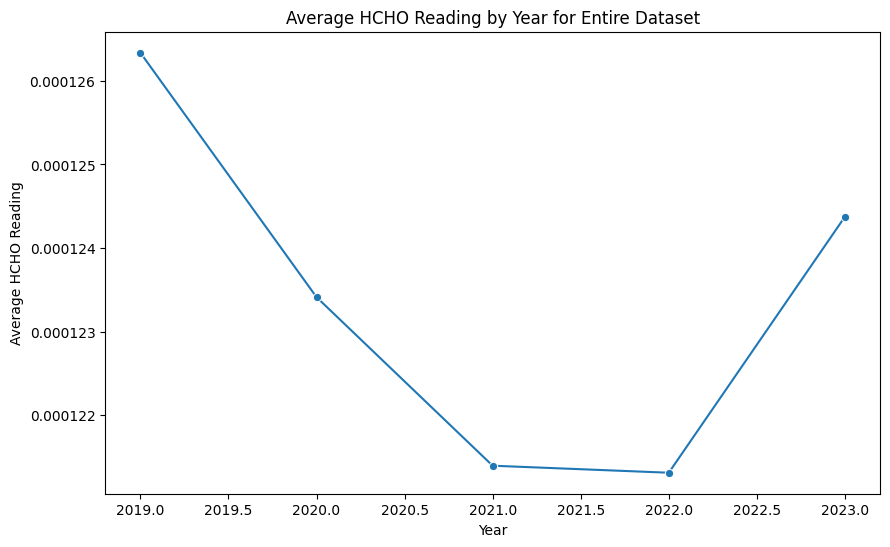

In [17]:
# Draw line plot for average hcho_reading by year for entire dataset
plt.figure(figsize=(10, 6))
sns.lineplot(data=year_hcho_reading, x="year", y="average_hcho_reading", marker='o')
plt.xlabel("Year")
plt.ylabel("Average HCHO Reading")
plt.title("Average HCHO Reading by Year for Entire Dataset")
plt.show()

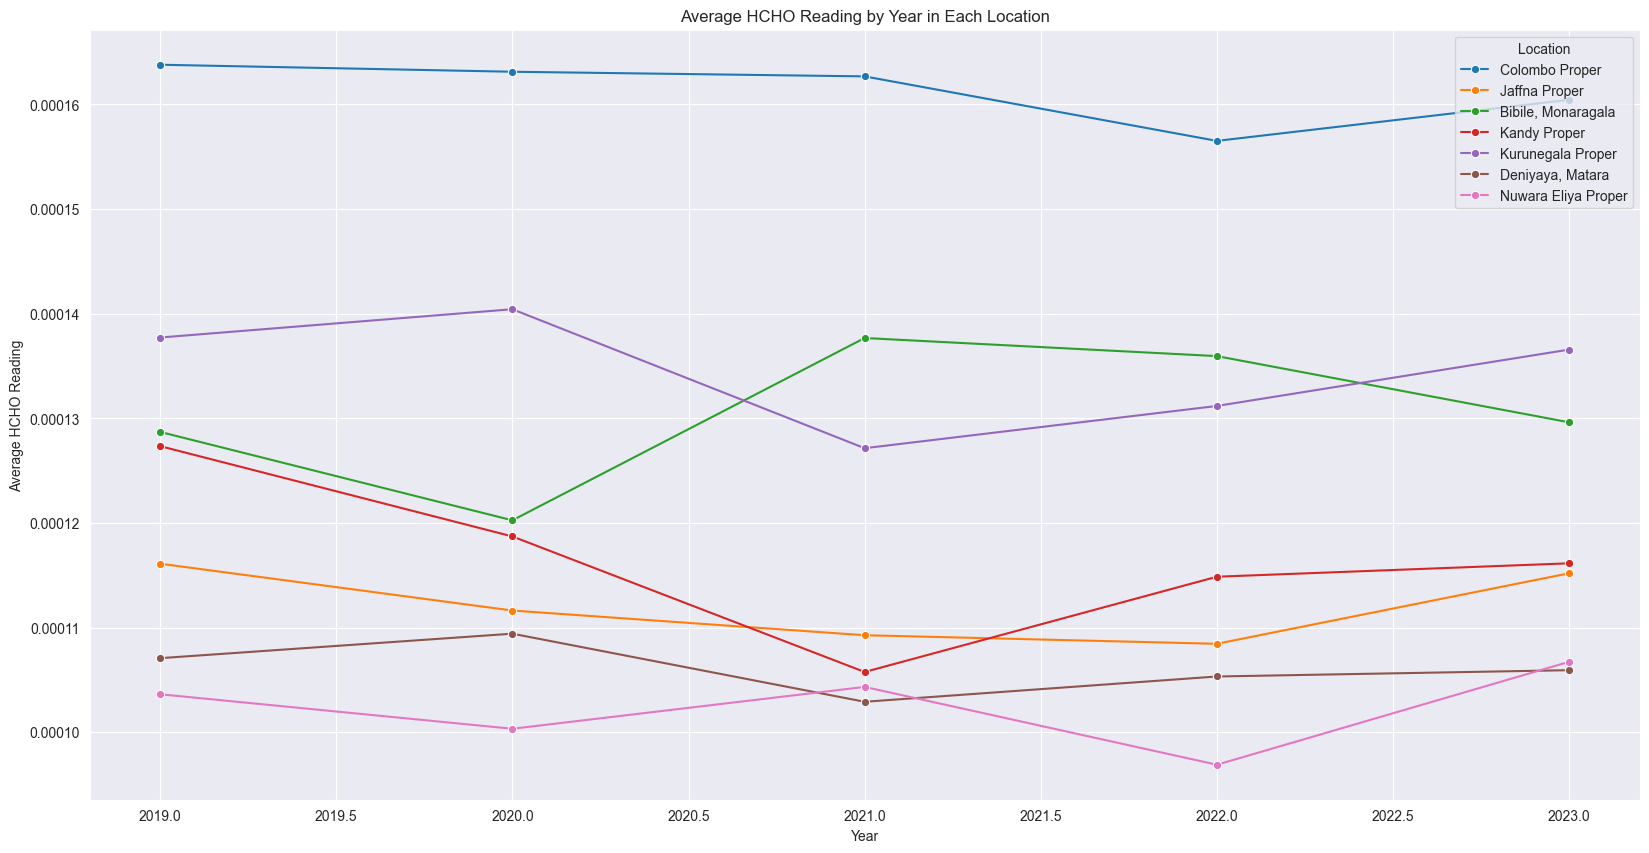

In [26]:
# Draw line plot for average hcho_reading by year for each city
plt.figure(figsize=(20, 10))

for location in locations:
    location_data = location_year_hcho_reading[location_year_hcho_reading["location"] == location]
    sns.lineplot(data=location_data, x="year", y="average_hcho_reading", marker='o', label=location)

plt.xlabel("Year")
plt.ylabel("Average HCHO Reading")
plt.title("Average HCHO Reading by Year in Each Location")
plt.legend(title="Location")
plt.show()